# Implementation of Multilayer Perceptrons

## Simple but important
Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual difference is that we now concatenate multiple linear layers (2-layer MLP as the figure below).

<img src="https://miro.medium.com/max/1400/1*-IPQlOd46dlsutIbUq1Zcw.webp" width=600 height=360>

However, the MLP serves as the dominant component for most research frameworks and practical algorithms, e.g., experts and gates within [MoE](https://en.wikipedia.org/wiki/Mixture_of_experts)/[MMoE](https://dl.acm.org/doi/pdf/10.1145/3219819.3220007), almost all prediction functions for industry systems.


## Table of Contents

- [Basic](https://d2l.ai/chapter_multilayer-perceptrons/mlp-implementation.html)
  - Implementation from Scratch with Torch Parameters
  - Concise Implementation with Torch Modules

- Advanced
  - Dynamic Parameter Implementation
  - Practical Style Implementation

## Preparation

### Install and import necessary libraries.

In [ ]:
pip install d2l

In [1]:
import torch
from torch import nn
from IPython import display
from d2l import torch as d2l

### Fashion MINIST data for illustration.

Download data by built-in function of d2l. Fashion-MNIST contains 10 classes, and that each image consists of 28 x 28 = 784 grid of grayscale pixel values. We disregard the spatial structure among the pixels for now, so we can think of this as a classification task with 784 input features and 10 classes.


## Basic Implementation
The first part is set for beginners to understand the basic concept of MLP and learn basic Torch coding.

### Implementation from Scratch

- Step 1: Define parameters (two layers) and the activation function (ReLU).
- Step 2: Define MLP.
- Step 3: Training and evaluation.

In [2]:
# Step 1

# non-linear activation functions to increase the expression of the model
# https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/activation.html#ReLU
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

# Params
num_inputs, num_outputs, num_hiddens = 784, 10, 256  # Define number of neurals in each layer.

class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))
# Step 2
    def forward(self, X):
      X = X.reshape((-1, self.num_inputs))
      H = relu(torch.matmul(X, self.W1) + self.b1)
      return torch.matmul(H, self.W2) + self.b2


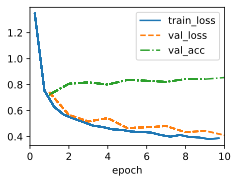

In [3]:
# Step 3
# Pipeline (Easy): https://github.com/rixwew/pytorch-fm/blob/master/examples/main.py
# Pipeline: https://github.com/reczoo/FuxiCTR/blob/d9a96c76d61b083738f5c96e82d4b8eb506c73c6/fuxictr/pytorch/models/rank_model.py#L137
# d2l: https://d2l.ai/_modules/d2l/torch.html#Trainer.fit $ https://d2l.ai/chapter_linear-regression/linear-regression-scratch.html#training
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### Concise Implementation

We could use torch modules (linear, activation...) for convenient MLP construction.

In [4]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
        # LazyLinear: https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html#lazylinear
    def forward(self,X):
      return self.net(X)



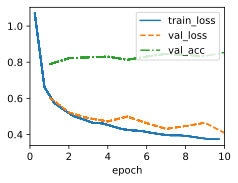

In [5]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Advanced Implementation

This part will provide two advanced implementations as examples, which may require more experience with Torch and preliminaries to understand.

The good news is that this part corresponds to the content of the previous one: implementation with parameters and modules.

### MLP with Dynamic Parameter

MLPs with dynamic parameters are very popular in different research topics and practical scenarios, e.g., [APG@Nips'22](https://arxiv.org/abs/2203.16218), [PEPNet@KDD'23](https://arxiv.org/abs/2302.01115), [HAMUR@CIKM'23](https://arxiv.org/abs/2309.06217).

Our lecture focuses on how to use the generated parameters and would not detail the parameter generation.




In [6]:
# Example Implementation
import torch.nn.functional as F
class MultiLayerPerceptronDP(torch.nn.Module):
    def __init__(self, input_dim, embed_dims, dropout, output_layer=1):
        super().__init__()
        self.output = bool(output_layer)
        self.weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for embed_dim in embed_dims:
            self.weights.append(nn.Parameter(torch.randn(input_dim,embed_dim)))
            self.biases.append(nn.Parameter(torch.randn(embed_dim)))
            self.batch_norms.append(nn.BatchNorm1d(embed_dim))
            self.dropouts.append(nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            self.weights.append(nn.Parameter(torch.randn(input_dim,output_layer)))
            self.biases.append(nn.Parameter(torch.randn(output_layer)))
        # self.reset_parameters()
        self.weights_shape = list(map(lambda x: list(x.shape),self.weights))
        self.bias_shape = list(map(lambda x: list(x.shape),self.biases))

    # def reset_parameters(self):
    #     for weight in self.weights:
    #         nn.init.kaiming_normal_(weight)
    #     for bias in self.biases:
    #         nn.init.zeros_(bias)

    def forward(self, x, custom_params):
        """
        :param x: Float tensor of size ``(batch_size, input_dim)``
        :param custom_params: Optional list of tuples containing custom weights and biases for each layer
        """
        batch_size = x.size(0)
        for i in range(len(self.weights) - int(self.output)):
            weight, bias = custom_params[0][i], custom_params[1][i]
            x = torch.bmm(x.unsqueeze(1), weight).squeeze(1) + bias
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = self.dropouts[i](x)

        # Apply the output layer if it exists
        if self.output:
            weight, bias = custom_params[0][-1], custom_params[1][-1]
            x = torch.bmm(x.unsqueeze(1), weight).squeeze(1) + bias
        return x

In [7]:
class MLPwithDP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens,num_inputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.MLP_P = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_inputs*num_outputs+num_outputs))
        self.MLP_DP = MultiLayerPerceptronDP(input_dim=num_inputs, embed_dims=[], dropout=0.2, output_layer=num_outputs)

    def forward(self,X):
      batch = X.shape[0]
      dp = self.MLP_P(X)
      return self.MLP_DP(X.reshape((-1, self.num_inputs)),[[dp[:,:num_inputs*num_outputs].view([batch,num_inputs,num_outputs])],[dp[:,num_inputs*num_outputs:]]])



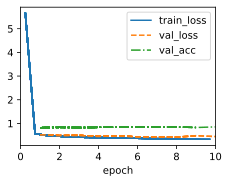

In [8]:
model = MLPwithDP(num_outputs=10, num_hiddens=256,num_inputs=784, lr=0.1)
trainer.fit(model, data)

### Practical Style

The concise implementation is very close to the coding in practice. However, the code should be more adaptive for industry use, where the number of layers, the activation function, and the use of normalization should be easily modified for debugging and hyper-parameter fine-tuning.


In [9]:
# Example Implementation
# Resource: https://github.com/reczoo/FuxiCTR/blob/main/fuxictr/pytorch/layers/blocks/mlp_block.py
class FullyConnectedLayer(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_unit,
                 batch_norm=False,
                 activation='relu',
                 sigmoid=False,
                 dropout=None):
        super(FullyConnectedLayer, self).__init__()
        assert len(hidden_unit) >= 1
        self.sigmoid = sigmoid

        layers = []
        layers.append(nn.Linear(input_size, hidden_unit[0]))

        for i, h in enumerate(hidden_unit[:-1]):
            if batch_norm:
                layers.append(nn.BatchNorm1d(hidden_unit[i]))

            if activation.lower() == 'relu':
                layers.append(nn.ReLU(inplace=True))
            elif activation.lower() == 'tanh':
                layers.append(nn.Tanh())
            elif activation.lower() == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            else:
                raise NotImplementedError

            if dropout is not None:
                layers.append(nn.Dropout(dropout))

            layers.append(nn.Linear(hidden_unit[i], hidden_unit[i + 1]))

        self.fc = nn.Sequential(*layers)
        if self.sigmoid:
            self.output_layer = nn.Sigmoid()

    def forward(self, x):
        return self.output_layer(self.fc(x)) if self.sigmoid else self.fc(x)

